In [7]:
import sys
sys.path.append("F:/skripsi/FAS-Skripsi-4")

from tqdm.notebook import tqdm
import torch
from torchvision.transforms import ToTensor, Normalize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import cv2
from face_detection import FaceDetection, FaceSelectionMethod
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from fas_simple_distill.model.resnet_ssdg.ssdg_resnet_baseline import DG_model

sys.path.remove("F:/skripsi/FAS-Skripsi-4")

In [8]:
root_path = "F:/skripsi/FAS-Skripsi-4/seaborn_data/casia_mfsd"
ckpt_path = "F:/skripsi/FAS-Skripsi-4/evaluator/weights/ssdg_baseline_OMItoC.pth"
max_subject = 20
distance_type = "cosine" # 'euclidean' or 'cosine'
device = "cuda" # 'cpu' or 'cuda'

ckpt = torch.load(ckpt_path)
model_ckpt = ckpt["model"]

model = DG_model(
    model="resnet18",
    embedding_size=512,
    drop_rate=0.0,
    norm_flag=True,
)

model.load_state_dict(model_ckpt)
model.to(device)

DG_model(
  (embedder): FeatureEmbedderResNetTorch(
    (backbone): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [9]:
class crop_align_face:
    def __init__(
        self,
        use_cuda: bool = True,
        no_rotate: bool = True,
        crop_size: int = 256,
        scale: float = 0.75,
        select_method = FaceSelectionMethod.AREA,
    ) -> None:
        use_onnx = not use_cuda
        self.fd = FaceDetection(use_cuda, no_rotate, use_onnx)
        self.crop_size = crop_size
        self.scale = scale
        self.select_method = select_method

    def __call__(self, x):
        if isinstance(x, Image.Image):
            input_is_pil = True
            x = np.array(x)
            x = cv2.cvtColor(x, cv2.COLOR_RGB2BGR)
        else:
            input_is_pil = False
        
        dets, angle = self.fd.predict(x)
        x_crop, _ = self.fd.align_single_face(x, dets, angle, self.crop_size, self.scale, self.select_method)

        if input_is_pil:
            x_crop = cv2.cvtColor(x_crop, cv2.COLOR_BGR2RGB)
            x_crop = Image.fromarray(x_crop)
        
        return x_crop

_crop_face = crop_align_face()
_to_tensor = ToTensor()
_normalize = Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
    # mean=[0.5, 0.5, 0.5],
    # std=[0.5, 0.5, 0.5],
)

def preprocess_data(image: np.ndarray) -> np.ndarray:
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    processed_data = Image.fromarray(rgb_image)
    processed_data = _crop_face(processed_data)
    processed_data = _to_tensor(processed_data)
    processed_data = _normalize(processed_data)
    return processed_data.unsqueeze(0).to(device)

In [10]:
img_paths = list(Path(root_path).rglob("*.png")) + list(Path(root_path).rglob("*.jpg")) + list(Path(root_path).rglob("*.jpeg"))
live_img_paths = []
live_subjects = []
spoof_img_paths = []
spoof_subjects = []

for img_path in img_paths:
    if not "live" in str(img_path) and not "real" in str(img_path):
        continue
    live_img_paths.append(img_path)
    live_subjects.append(str(img_path.stem).split("_")[0])

for img_path in img_paths:
    if "live" in str(img_path) or "real" in str(img_path):
        continue
    spoof_img_paths.append(img_path)
    spoof_subjects.append(str(img_path.stem).split("_")[0])

live_subjects = np.asarray(live_subjects)
spoof_subjects = np.asarray(spoof_subjects)

live_num_subjects = np.unique(live_subjects, return_counts=True)[1]
spoof_num_subjects = np.unique(spoof_subjects, return_counts=True)[1]

del img_paths, live_subjects, spoof_subjects

# Live Class

In [11]:
dist_data = np.zeros((max_subject, max_subject))
visited_subject = []

for img_path_1 in tqdm(live_img_paths):
    # subject_1 = str(img_path_1.stem).split("_")[0]
    subject_1 = str(img_path_1).split("\\")[5]
    if subject_1 in visited_subject:
        continue
    
    img_1 = cv2.imread(str(img_path_1))
    data_1 = preprocess_data(img_1)
    feat_1 = model(data_1)[1].cpu().detach().numpy()

    for img_path_2 in live_img_paths:
        if img_path_1 == img_path_2:
            continue

        # subject_2 = str(img_path_2.stem).split("_")[0]
        subject_2 = str(img_path_2).split("\\")[5]

        img_2 = cv2.imread(str(img_path_2))
        data_2 = preprocess_data(img_2)
        feat_2 = model(data_2)[1].cpu().detach().numpy()

        if distance_type == "euclidean":
            dist = euclidean_distances(feat_1, feat_2)
        else:
            dist = cosine_distances(feat_1, feat_2)

        dist_data[int(subject_1) - 1][int(subject_2) - 1] += dist[0][0]
    
    visited_subject.append(subject_1)

for i in range(max_subject):
    for j in range(max_subject):
        dist_data[i][j] /= live_num_subjects[j]

  0%|          | 0/120 [00:00<?, ?it/s]

In [12]:
df = pd.DataFrame(dist_data)
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.000000,0.524685,0.280717,0.560482,0.407132,0.281982,0.336119,0.692636,0.262770,0.662145,0.315929,0.594512,-0.113834,0.280453,0.220650,0.138586,0.357746,-0.046490,0.315847,0.339050
1,0.524685,1.000000,-0.194268,0.349167,0.046028,-0.265111,0.307747,0.570948,0.101179,0.053892,0.430762,0.273680,0.168688,0.200830,0.384359,-0.124131,0.566994,-0.232884,0.251952,0.357092
2,0.280717,-0.194268,1.000000,0.189391,0.544634,0.694797,0.468857,0.264323,0.698977,0.645594,0.153376,0.688850,0.168948,0.637488,-0.237600,0.720510,0.105392,0.690904,0.609385,0.300742
3,0.560482,0.349167,0.189391,1.000000,0.345078,0.357840,0.484697,0.646395,0.241595,0.488162,0.441172,0.610360,0.279919,0.504722,0.319779,0.244096,0.662392,0.246759,0.535825,0.718010
4,0.407132,0.046028,0.544634,0.345078,1.000000,0.677098,0.571600,0.519999,0.680016,0.509439,0.535389,0.729436,0.247712,0.585083,0.352739,0.581239,0.322941,0.614665,0.652963,0.475415
5,0.281982,-0.265111,0.694797,0.357840,0.677098,1.000000,0.461841,0.407761,0.691830,0.655506,0.068133,0.662525,-0.067286,0.493895,0.074110,0.761071,0.034033,0.719803,0.559452,0.362540
6,0.336119,0.307747,0.468857,0.484697,0.571600,0.461841,1.000000,0.642386,0.657643,0.415064,0.609654,0.724859,0.400197,0.812355,0.341507,0.595112,0.648569,0.653265,0.715835,0.624710
7,0.692636,0.570948,0.264323,0.646395,0.519999,0.407761,0.642386,1.000000,0.543323,0.526247,0.533478,0.720810,0.220217,0.524514,0.492712,0.369551,0.551900,0.286782,0.542657,0.669080
8,0.262770,0.101179,0.698977,0.241595,0.680016,0.691830,0.657643,0.543323,1.000000,0.467700,0.396666,0.708247,0.323906,0.672743,0.120139,0.782291,0.305604,0.700895,0.694682,0.504188
9,0.662145,0.053892,0.645594,0.488162,0.509439,0.655506,0.415064,0.526247,0.467700,1.000000,0.007025,0.606075,-0.204367,0.356481,-0.173465,0.498832,0.184972,0.395064,0.399951,0.369534


<AxesSubplot: >

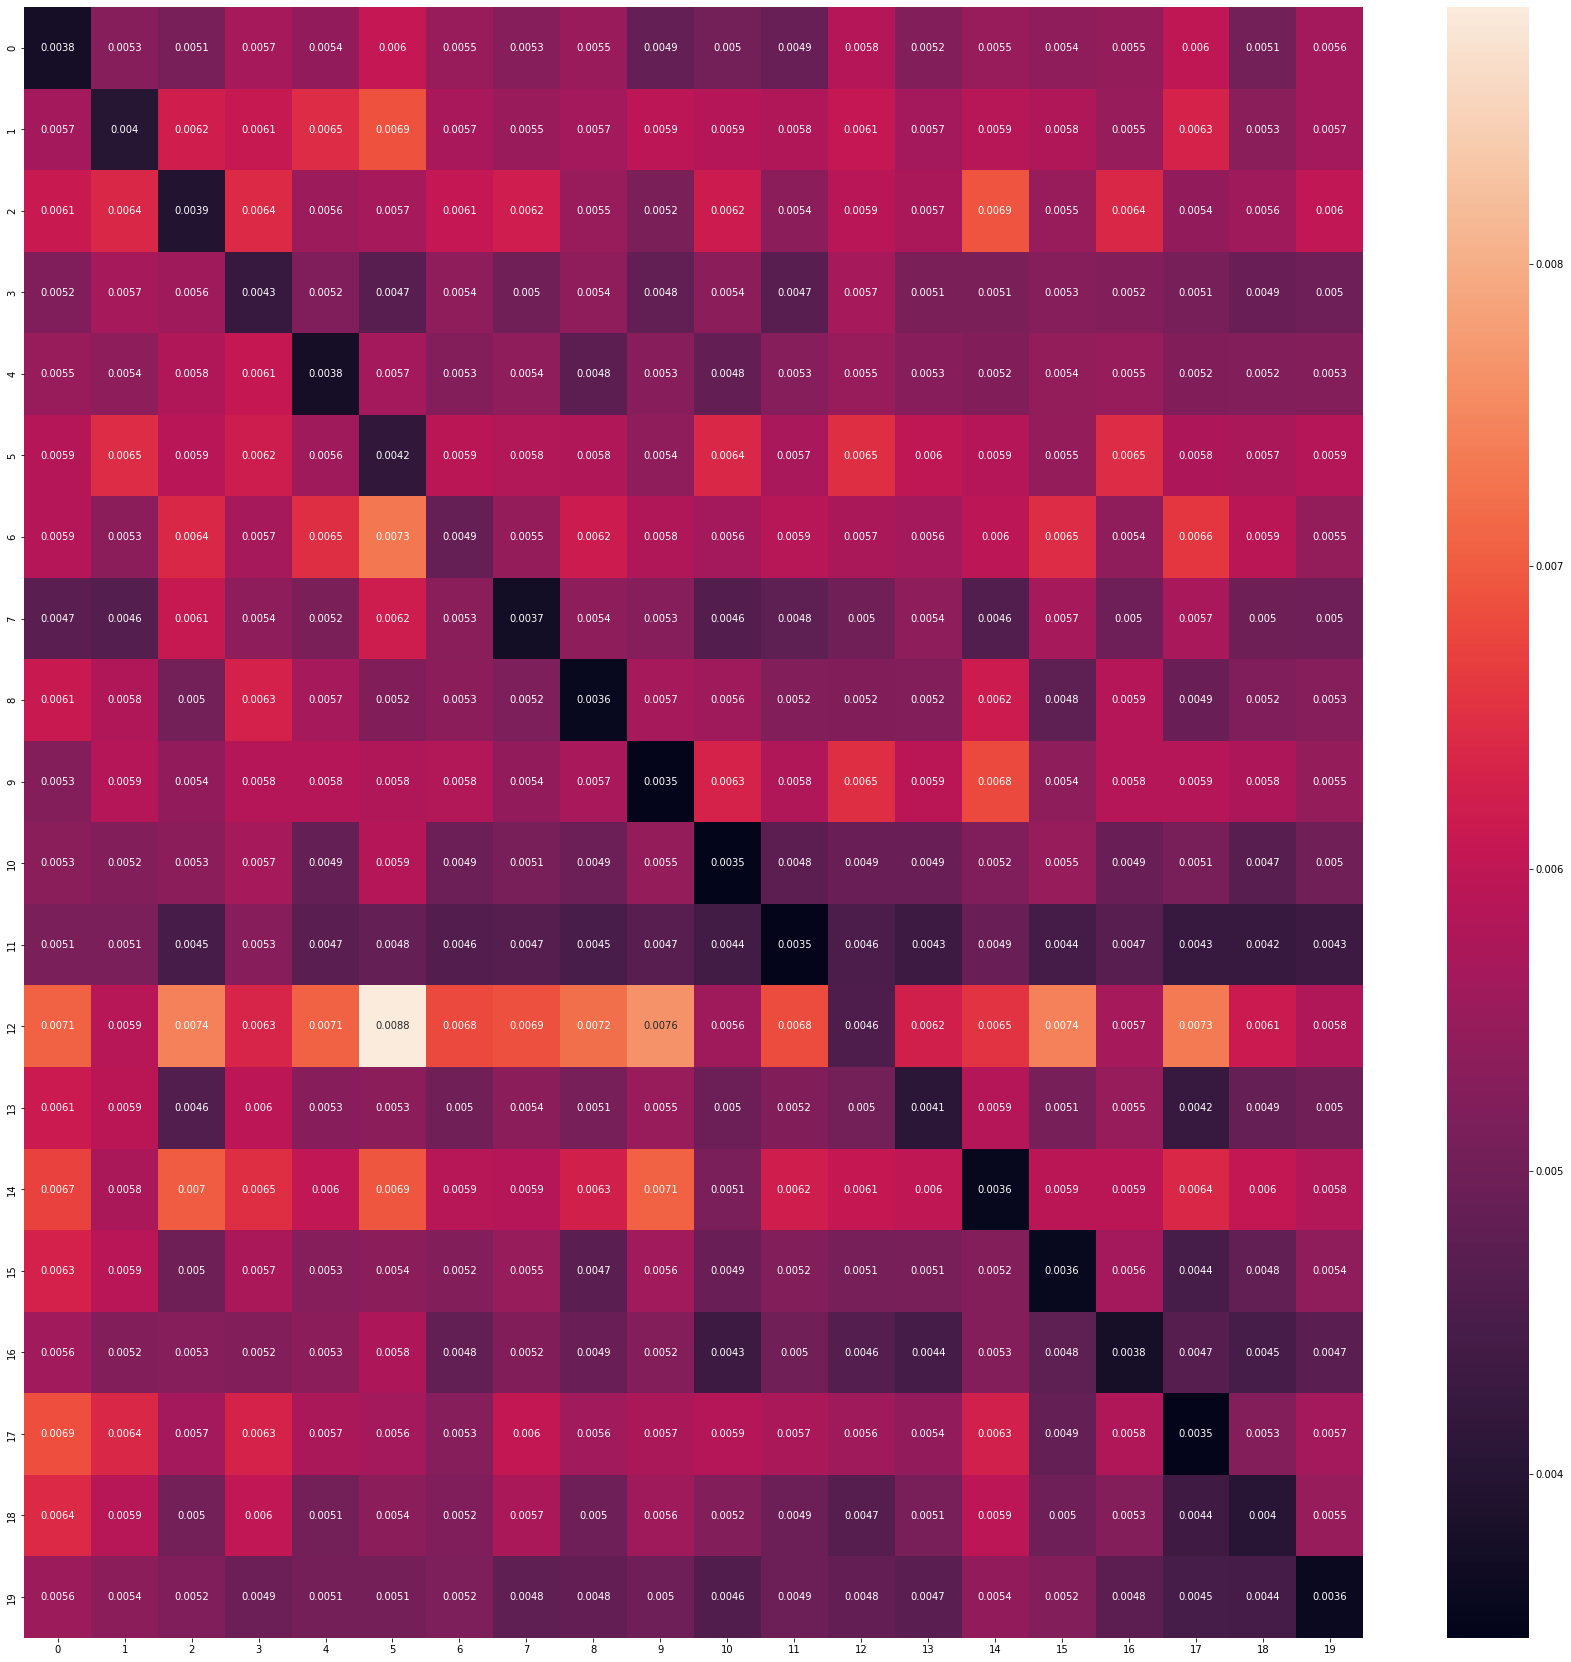

In [13]:
ax = plt.figure("Seaborn Heatmap", (30, 30))
sns.heatmap(dist_data, annot=True, cbar=True)

# Spoof Class

In [14]:
# dist_data = np.zeros((max_subject, max_subject))
# visited_subject = []

# for img_path_1 in tqdm(spoof_img_paths):
#     # subject_1 = str(img_path_1.stem).split("_")[0]
#     subject_1 = str(img_path_1).split("\\")[5]
#     if subject_1 in visited_subject:
#         continue
    
#     img_1 = cv2.imread(str(img_path_1))
#     data_1 = preprocess_data(img_1)
#     feat_1 = model(data_1)[1].cpu().detach().numpy()

#     for img_path_2 in spoof_img_paths:
#         if img_path_1 == img_path_2:
#             continue

#         # subject_2 = str(img_path_2.stem).split("_")[0]
#         subject_2 = str(img_path_2).split("\\")[5]

#         img_2 = cv2.imread(str(img_path_2))
#         data_2 = preprocess_data(img_2)
#         feat_2 = model(data_2)[1].cpu().detach().numpy()

#         if distance_type == "euclidean":
#             dist = euclidean_distances(feat_1, feat_2)
#         else:
#             dist = cosine_distances(feat_1, feat_2)

#         dist_data[int(subject_1) - 1][int(subject_2) - 1] += dist[0][0]
    
#     visited_subject.append(subject_1)

# for i in range(max_subject):
#     for j in range(max_subject):
#         dist_data[i][j] /= live_num_subjects[j]

In [15]:
# ax = plt.figure("Seaborn Heatmap", (30, 30))
# sns.heatmap(dist_data, annot=True, cbar=True)